# **Marketing - Final Artificial Intelligence Project**

## **Business Understanding**

**Marketing Problem:**

Customers and businesses are facing a significant marketing challenge: the vast amount of reviews left on Google Maps makes it difficult to efficiently analyze and understand customer sentiment. This lack of insight hinders businesses from effectively gauging customer satisfaction with their products, services, and overall experience. Manually sifting through large numbers of reviews is time-consuming and cumbersome, making it hard to identify trends, prioritize areas for improvement, or measure the impact of marketing campaigns. As a result, valuable customer feedback might go unnoticed, leading to missed opportunities for improvement and potentially negative customer experiences. Businesses might also struggle to respond promptly to negative reviews or invest resources in addressing issues that are not the primary drivers of customer dissatisfaction. Overall, the lack of efficient customer sentiment analysis within Google Maps reviews creates a barrier to understanding customer perception, hindering businesses from making data-driven decisions and achieving long-term success.

**Business Goals:**


*   Enhance customer relationship management by gaining deeper insights into customer experiences and feedback.
*   Improve brand reputation by identifying areas for improvement based on sentiment analysis of reviews.
*   Develop targeted marketing strategies by understanding customer preferences and suggestions revealed in reviews.

**AI Solution:**

This project proposes an AI-powered solution that leverages Google Maps API, BigQuery, and Gemini AI to analyze customer reviews on places of interest and deliver a consolidated report via email.

* Google Maps API: Enables businesses to access reviews left on their listings or those of competitors.
* BigQuery: Provides a scalable platform to store and manage the large volume of Google Maps reviews.
* Gemini AI: Analyzes the reviews to understand customer opinions, identifies key takeaways and suggestions, and generates recommendations.


**Benefits:**

* Businesses receive a concise summary of customer reviews, saving them time and effort in data analysis.
* Sentiment analysis helps businesses understand the overall customer perception of their brand and services.
* Key takeaways and suggestions provide actionable insights for improving customer experience and addressing potential issues.
* Recommendations based on review analysis offer valuable guidance for developing targeted marketing campaigns.

## **Data Understanding**

**Objective:** Aims to understand the data required to analyze customer sentiment and generate insights from Google Maps reviews for businesses.

**Data Sources:** There are two primary data sources involved in this project:


* Google Maps API: This API will be used to retrieve relevant reviews for a specific place or location chosen by the business.
* BigQuery: This cloud data warehouse that will store the retrieved reviews from Google Maps


**Data Exploration:**


3.1 Sample Data Analysis


A sample set of reviews was retrieved from Google Maps API and stored in BigQuery for analysis. This sample was used to understand the following:

* Sentiment Distribution: Sentiment analysis was performed on the sample data to understand the percentage of positive, negative reviews.
* Keyword Analysis: Techniques like word clouds analysis were used to identify frequently occurring keywords or phrases in the reviews. This can reveal common themes or topics mentioned by customers, providing valuable insights


3.2 Data Volume

* While the Google Maps API limits the number of retrievable reviews at a given time, the volume can still be significant depending on the size and popularity of the business. Despite the API limitations, this project is designed with scalability in mind. BigQuery's architecture allows us to efficiently handle  increasing data volumes as the need arises.

3.3 Data Quality

* The sample data was checked for missing values in key fields like review text or rating. Inconsistencies, such as invalid rating values or nonsensical review text, were identified and addressed to ensure data quality.

3.4 Outliers

* While outliers in review data are less likely due to the human-generated nature of reviews, a basic check was conducted. Reviews with exceptionally long text lengths or extreme outliers in ratings.

**Findings and Observations:**
The initial data exploration of these Google Maps reviews provided valuable insights that can inform business strategy:

* The review length distribution helps understand the typical amount of information customers provide in their reviews.
* The sentiment distribution offers a preliminary understanding of customer satisfaction with the businesses.
* Keyword/phrase analysis can reveal common themes and topics mentioned in reviews, allowing businesses to identify areas for improvement or highlight strengths.

# **Implementation**

In [1]:
# Load your Service Account
import os
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = "sanil_fernandes_s24.json"

In [2]:
#Loading the Libraries
import urllib.parse
import requests
import pprint
import pandas as pd

In [3]:
# Read your Google Maps API key from Google Colab Notebook secret
from google.colab import userdata
googleMapsKey = userdata.get('google-maps-key')

In [4]:
# To initialize the gcloud CLI
!gcloud init

Welcome! This command will take you through the configuration of gcloud.

Settings from your current configuration [default] are:
component_manager:
  disable_update_check: 'True'
compute:
  gce_metadata_read_timeout_sec: '0'

Pick configuration to use:
 [1] Re-initialize this configuration [default] with new settings 
 [2] Create a new configuration
Please enter your numeric choice:  1

Your current configuration has been set to: [default]

You can skip diagnostics next time by using the following flag:
  gcloud init --skip-diagnostics

Network diagnostic detects and fixes local network connection issues.
Reachability Check passed.
Network diagnostic passed (1/1 checks passed).

You must log in to continue. Would you like to log in (Y/n)?  Y

Go to the following link in your browser, and complete the sign-in prompts:

    https://accounts.google.com/o/oauth2/auth?response_type=code&client_id=32555940559.apps.googleusercontent.com&redirect_uri=https%3A%2F%2Fsdk.cloud.google.com%2Fauthc

In [5]:
# Enable the Cloud Natural Language API
!gcloud services enable language.googleapis.com

In [6]:
# Install the google-cloud-language package
!pip install google-cloud-language

# Imports the Google Cloud client library
from google.cloud import language_v1

# Instantiates a client
client = language_v1.LanguageServiceClient()

In [69]:
# Google Maps Geocoding API Client
import requests
from urllib.parse import urlencode
import pprint

def geoCodePlace(place):
  """Returns the geoCodedPlace for the given place"""

  url = "https://maps.googleapis.com/maps/api/geocode/json"
  params = {"address": place, "key": googleMapsKey}
  response = requests.get(url, params=urlencode(params))
  return response.json()

# Prompt user for favorite place
place = input("Enter your prefered Place: ")

Enter your prefered Place: Stages NightClub


In [70]:
# Get the geoCodedPlace
geoCodedPlace = geoCodePlace(place)
print("\nThis is the geoCodedPlace for", place + ":")
pprint.pprint(geoCodedPlace)


This is the geoCodedPlace for Stages NightClub:
{'results': [{'address_components': [{'long_name': '390',
                                      'short_name': '390',
                                      'types': ['street_number']},
                                     {'long_name': 'Princess Street',
                                      'short_name': 'Princess St',
                                      'types': ['route']},
                                     {'long_name': 'Kingston',
                                      'short_name': 'Kingston',
                                      'types': ['locality', 'political']},
                                     {'long_name': 'Kingston',
                                      'short_name': 'Kingston',
                                      'types': ['administrative_area_level_3',
                                                'political']},
                                     {'long_name': 'Frontenac County',
                             

In [8]:
# Get the place id
place_id = geoCodedPlace["results"][0]["place_id"]
print("\nThis is the place id:")
print(place_id)


This is the place id:
ChIJwxdETQer0kwRnHOWYjaTiIQ


In [9]:
# Google Places API - Get Place Details
def getPlaceDetails(place_id):
    """Returns the place details for the given place id"""

    url = "https://places.googleapis.com/v1/places/{}".format(place_id)
    params = {
        "fields": "id,displayName,rating,userRatingCount,reviews",
        "key": googleMapsKey,
    }
    response = requests.get(url, params=urllib.parse.urlencode(params))
    return response.json()

# Get the place details
placeDetails = getPlaceDetails(place_id)
print("\nThese are the place details:")
pprint.pprint(placeDetails)


These are the place details:
{'displayName': {'languageCode': 'en', 'text': 'Stages Nightclub'},
 'id': 'ChIJwxdETQer0kwRnHOWYjaTiIQ',
 'rating': 2.5,
 'reviews': [{'authorAttribution': {'displayName': 'Kate M',
                                    'photoUri': 'https://lh3.googleusercontent.com/a/ACg8ocIaaHfn_ndySPfyAaeLfx5YvuFnxmCgI-gf3XKzk82NMgzJ2Hc=s128-c0x00000000-cc-rp-mo',
                                    'uri': 'https://www.google.com/maps/contrib/101540012303071291581/reviews'},
              'name': 'places/ChIJwxdETQer0kwRnHOWYjaTiIQ/reviews/ChZDSUhNMG9nS0VJQ0FnSUNUeThMSmZREAE',
              'originalText': {'languageCode': 'en',
                               'text': 'the bouncer didn’t believe my friends '
                                       'ID was real….shes 24…he’s a loser…you '
                                       'let in underage people but not of age '
                                       'people? That’s concerning and you '
                                

In [10]:
# Create an empty DataFrame
df_reviews = pd.DataFrame(columns=['publishTime', 'displayName', 'originalText', 'rating'])

# Extract reviews and populate the DataFrame
for review in placeDetails['reviews']:
    review_data = {
        'publishTime': review['publishTime'],
        'displayName': review['authorAttribution']['displayName'],
        'originalText': review['originalText']['text'],
        'rating': review['rating']
    }
    df_reviews.loc[len(df_reviews)] = review_data

In [11]:
# Display the DataFrame
df_reviews.head()

,publishTime,displayName,originalText,rating
0,2024-05-19T05:48:58Z,Kate M,the bouncer didn’t believe my friends ID was r...,1
1,2024-04-28T08:29:09Z,Dianna Filippelli,My review may sharply contrast with the aforem...,5
2,2024-02-04T06:58:32Z,Emma D,"I used to love this place, but the new DJ is t...",1
3,2024-06-21T04:49:27Z,Nut S.,You need to pay cash before going in as an ent...,1
4,2024-03-16T15:04:38Z,olivia carter,stages has really gone down hill since last ye...,1


In [12]:
# Save DataFrame as CSV
df_reviews.to_csv('reviews.csv', index=False)

In [13]:
# Load the existing CSV file
df_reviews = pd.read_csv('reviews.csv')

## **Data Preparation**

Data Transformation:

* Feature Engineering: Created new features from existing data that be more informative for sentiment analysis models. This involves:
  * Extracting sentiment scores from review text using pre-trained sentiment analysis libraries.
  * Identifying parts-of-speech to understand the emotional tone of the review.
* Creating bag-of-words features that represent the presence or absence of specific words in the review.


Data Structuring:

* Design a schema for the prepared data in the BigQuery. This schema define tables, columns, and data types to efficiently store and manage the processed data. The schema is designed to accommodate the features created during transformation.

Data Storage:

* This prepared data will be loaded into a BigQuery table for efficient storage, scalability, and further analysis. Libraries like google.cloud.bigquery is used programmatically to upload the DataFrame containing the prepared data to BigQuery.

In [14]:
# Detects the sentiment of the text
def analyze_sentiment(text):
    document = language_v1.Document(content=text, type_=language_v1.Document.Type.PLAIN_TEXT)
    sentiment = client.analyze_sentiment(request={"document": document}).document_sentiment
    return sentiment.score, sentiment.magnitude

In [15]:
# Add sentiment and magnitude to each review
df_reviews['sentiment'] = None
df_reviews['magnitude'] = None

for index, row in df_reviews.iterrows():
    text = row['originalText']
    sentiment_score, sentiment_magnitude = analyze_sentiment(text)
    df_reviews.at[index, 'sentiment'] = sentiment_score
    df_reviews.at[index, 'magnitude'] = sentiment_magnitude

In [64]:
# Display the updated DataFrame
df_reviews.head()

,publishTime,displayName,originalText,rating,sentiment,magnitude
0,2024-05-19T05:48:58Z,Kate M,the bouncer didn’t believe my friends ID was r...,1,-0.8,1.6
1,2024-04-28T08:29:09Z,Dianna Filippelli,My review may sharply contrast with the aforem...,5,-0.3,9.6
2,2024-02-04T06:58:32Z,Emma D,"I used to love this place, but the new DJ is t...",1,-0.5,2.1
3,2024-06-21T04:49:27Z,Nut S.,You need to pay cash before going in as an ent...,1,-0.8,1.6
4,2024-03-16T15:04:38Z,olivia carter,stages has really gone down hill since last ye...,1,-0.8,1.7


In [17]:
# Save the updated DataFrame back to a CSV file
df_reviews.to_csv('reviews_with_sentiment.csv', index=False)

In [18]:
# Store the extracted Sentiiment to Big Query

from google.cloud import bigquery
from google.auth import default

# Initialize BigQuery client
client = bigquery.Client()
credentials, project_id = default()
client = bigquery.Client(credentials=credentials, project=project_id)

# Create a new BigQuery dataset
dataset_id = "sentiment_analysis"
dataset_ref = client.dataset(dataset_id)
dataset = bigquery.Dataset(dataset_ref)
client.create_dataset(dataset, exists_ok=True)

# Define the schema for the BigQuery table
schema = [
    bigquery.SchemaField("publishTime", "TIMESTAMP"),
    bigquery.SchemaField("displayName", "STRING"),
    bigquery.SchemaField("originalText", "STRING"),
    bigquery.SchemaField("rating", "FLOAT"),
    bigquery.SchemaField("sentiment", "FLOAT"),
    bigquery.SchemaField("magnitude", "FLOAT"),
]

# Create a new BigQuery table
table_id = "reviews_with_sentiment"
table_ref = dataset.table(table_id)
table = bigquery.Table(table_ref, schema=schema)
client.create_table(table, exists_ok=True)

# Load the DataFrame into the BigQuery table
job_config = bigquery.LoadJobConfig(
    write_disposition="WRITE_TRUNCATE",
)
job = client.load_table_from_dataframe(df_reviews, table_ref, job_config=job_config)
job.result()

print("Reviews with sentiment data saved to BigQuery table:")
print("- Dataset: {}".format(dataset_id))
print("- Table: {}".format(table_id))

Reviews with sentiment data saved to BigQuery table:
- Dataset: sentiment_analysis
- Table: reviews_with_sentiment


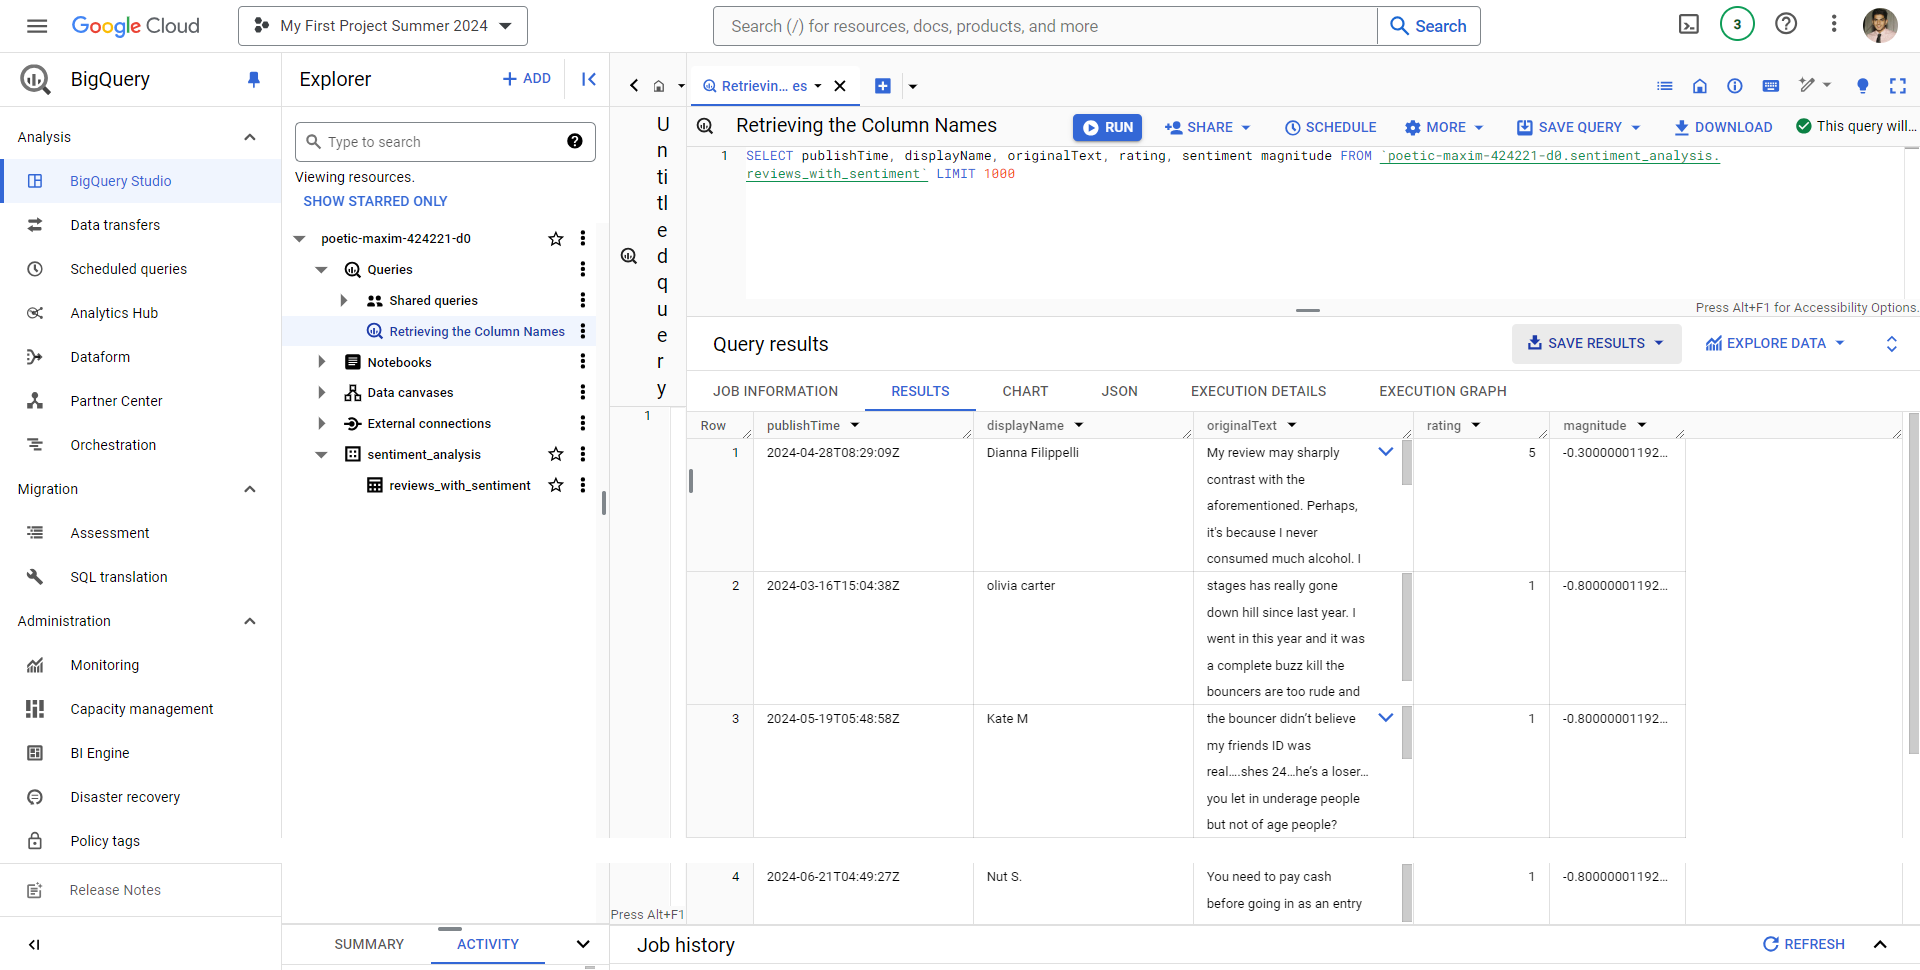

In [20]:
# Compute Sentiment and Magnitude averages
average_sentiment = df_reviews['sentiment'].mean()
average_magnitude = df_reviews['magnitude'].mean()
print(f"Average Sentiment: {average_sentiment/2:.2f}")
print(f"Average Magnitude: {average_magnitude/2:.2f}")

Average Sentiment: -0.32
Average Magnitude: 1.66


In [24]:
# Creating Wordclod from extracted Reviews
from wordcloud import WordCloud
import matplotlib.pyplot as plt

In [25]:
# Create a variable with all reviews
all_reviews = ' '.join(text for text in df_reviews['originalText'])

def wordcloud(txt):
    wordcloud = WordCloud(max_font_size=50, max_words=100, background_color='white').generate(txt)
    plt.figure()
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    return wordcloud

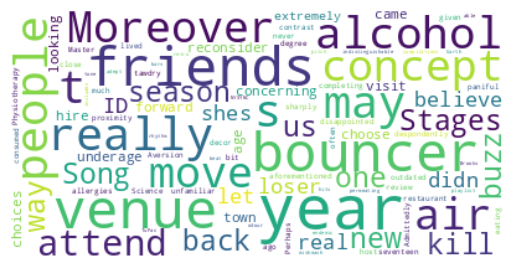

In [26]:
# Save the wordcloud as an image file
wordcloud(all_reviews).to_file('wordcloud.png')

In [65]:
# Store above Word Cloud in GCP and Generate a Unquie Link

from google.cloud import storage

# Create a storage client.
storage_client = storage.Client()

# Create a bucket object.
bucket = storage_client.bucket("my_final_project")

# Create a blob object.
blob = bucket.blob("images/wordcloud.png")

# Upload the image to the bucket.
blob.upload_from_filename("wordcloud.png")

# Get the URL of the image.
image_url = blob.public_url

# Use the image URL in HTML.
html_code = f"""
<img src="{image_url}" alt="Word Cloud">
"""

# Save the HTML code to a file.
with open("wordcloud.html", "w") as f:
    f.write(html_code)

In [66]:
# Generate Signed URL for Google Cloud Storage
from google.cloud import storage
import datetime
from datetime import timedelta

def get_signed_url(bucket_name, object_name):
    client = storage.Client()
    bucket = client.get_bucket(bucket_name)
    blob = bucket.blob(object_name)
    url = blob.generate_signed_url(
        expiration=timedelta(minutes=10),
        method="GET",
    )
    return url

In [67]:
print(get_signed_url("my_final_project", "images/wordcloud.png"))

https://storage.googleapis.com/my_final_project/images/wordcloud.png?Expires=1720033497&GoogleAccessId=sanil-fernandes-2408%40poetic-maxim-424221-d0.iam.gserviceaccount.com&Signature=hQFjgVOBEiStl2RG%2BFjQ6IuyAvcF%2BCOYJgoZusNWLVv%2FTUZnqKMM4zGlpPu8DxZM%2FIY2SWwwviQD%2BI0xOFZ5VxvgRpdwy880OhzP8%2BHwcHigpGB7ZXYI3%2ByxeUL9FaPFmYFY0JBJkL6kG%2B0%2BbyJD3TvDi3TbfRG%2B5HmrSed3rGQBHyU6%2BUWyTWC%2F80%2BjOVq3J4%2B1dc3L2iQIG2SWOLo1PHVX34m3ZTGxREJX%2BIETQRxDalnr%2B9IwadgV9gkKkfzo87sddwCJpBbw4Wjg3iAiFn9cVRu2LGJe7i7fOxwGXSOL9m3SrUIpcqi6Hh45te9p6JOzo%2BsGtMwfygwaDWapIg%3D%3D


In [30]:
# Load the existing CSV file
df_rws = pd.read_csv('/content/reviews_with_sentiment.csv')
df_rws.head()

,publishTime,displayName,originalText,rating,sentiment,magnitude
0,2024-05-19T05:48:58Z,Kate M,the bouncer didn’t believe my friends ID was r...,1,-0.8,1.6
1,2024-04-28T08:29:09Z,Dianna Filippelli,My review may sharply contrast with the aforem...,5,-0.3,9.6
2,2024-02-04T06:58:32Z,Emma D,"I used to love this place, but the new DJ is t...",1,-0.5,2.1
3,2024-06-21T04:49:27Z,Nut S.,You need to pay cash before going in as an ent...,1,-0.8,1.6
4,2024-03-16T15:04:38Z,olivia carter,stages has really gone down hill since last ye...,1,-0.8,1.7


In [31]:
df_rws_dropped = df_rws.drop(columns=['publishTime', 'displayName', 'rating', 'sentiment', 'magnitude'])
df_rws_dropped.head()

,originalText
0,the bouncer didn’t believe my friends ID was r...
1,My review may sharply contrast with the aforem...
2,"I used to love this place, but the new DJ is t..."
3,You need to pay cash before going in as an ent...
4,stages has really gone down hill since last ye...


# **Vertex AI Generative Model - Text Summarization with Feedback Analysis**

In [32]:
import vertexai
from vertexai.generative_models import GenerativeModel
import time
import json

# TODO(developer): Update and un-comment below line
project_id = "poetic-maxim-424221-d0"

vertexai.init(project=project_id, location="us-central1")  # Pass the project_id variable

model = GenerativeModel(model_name="gemini-1.5-flash", generation_config={"response_mime_type": "application/json"})

# Get user input for the prompt
prompt1 = "In one sentences  1.Provide key takeaways, 2.Suggestions for improvement. 3.What is the sentiment positive or negative from the reviewers? 4.Can you recommend what the business can take to address feedback? This is your text source:"

# Store all responses and corresponding original texts
all_responses = []

# Iterate over each row in the Series and generate content individually
for index, text in df_rws_dropped['originalText'].items(): # Iterate over the 'originalText'
  complete_prompt = prompt1 + text
  response = model.generate_content(complete_prompt)
  text_response = response.text

  # Store the original text and response
  all_responses.append((text, response))

  # Update the corresponding row
  df_rws_dropped.loc[index, "Response"] = text_response

  time.sleep(5)

In [33]:
# Print all responses
for text, response in all_responses:
    print(f"Original Text:\n{text}\n")
    json_response = json.loads(response.text)
    for key, value in json_response.items():
        print(f"{key}: {value}")
    print("-" * 30)

Original Text:
the bouncer didn’t believe my friends ID was real….shes 24…he’s a loser…you let in underage people but not of age people? That’s concerning and you should really reconsider your choices of who you choose to hire as bouncers, my friends came from out of town to visit me and we had been looking forward to this for a while, extremely disappointed

key_takeaways: The reviewer had a negative experience due to a bouncer questioning a valid ID and concerns about the establishment's age verification practices.
suggestions_for_improvement: The establishment should review its bouncer training and policies related to age verification and ID checking to ensure fairness and accuracy.
sentiment: negative
recommendations: The business should implement stricter training for bouncers on ID verification protocols and ensure consistent application of age restrictions to avoid such incidents.
------------------------------
Original Text:
My review may sharply contrast with the aforementione

In [34]:
# Create a new DataFrame to store the key takeaways, suggestions, sentiment, and recommendations
df_key_takeaways = pd.DataFrame(columns=['Original Text', 'Key Takeaways', 'Suggestions for Improvement', 'Sentiment', 'Recommendations'])

# Iterate over each row in the original DataFrame
for index, row in df_rws_dropped.iterrows():
    # Extract the original text
    original_text = row['originalText']

    # Extract the response
    response = row['Response']

    # Convert the response to a JSON object
    json_response = json.loads(response)

    # Extract the key takeaways, suggestions, sentiment, and recommendations from the JSON object
    key_takeaways = json_response.get('key_takeaways', '')
    suggestions = json_response.get('suggestions_for_improvement', '')
    sentiment = json_response.get('sentiment', '')
    recommendations = json_response.get('recommendations', '')

    # Store the extracted information in the new DataFrame
    df_key_takeaways.loc[index] = [original_text, key_takeaways, suggestions, sentiment, recommendations]

# Display the new DataFrame
df_key_takeaways.head()

,Original Text,Key Takeaways,Suggestions for Improvement,Sentiment,Recommendations
0,the bouncer didn’t believe my friends ID was r...,The reviewer had a negative experience due to ...,The establishment should review its bouncer tr...,negative,The business should implement stricter trainin...
1,My review may sharply contrast with the aforem...,"The reviewer expresses aversion to alcohol, fi...","The reviewer suggests updating the decor, impr...",negative,The business could address the feedback by upd...
2,"I used to love this place, but the new DJ is t...",The reviewer is unhappy with the new DJ's musi...,The business should consider replacing the cur...,negative,The business could address the feedback by cha...
3,You need to pay cash before going in as an ent...,The review highlights issues with the cash-onl...,The business should consider accepting card pa...,negative,The business should address the concerns about...
4,stages has really gone down hill since last ye...,Reviewers are dissatisfied with the recent dec...,Stages should prioritize improving customer se...,negative,Implementing customer service training for bou...


In [35]:
# Get the head (first few rows) of the DataFrame
df_head = df_key_takeaways.head()

# Create an HTML table string
html_table = """
<table border="1" style="width:100%">
  <tr>
    <th>Original Text</th>
    <th>Key Takeaways</th>
    <th>Suggestions for Improvement</th>
    <th>Sentiment</th>
    <th>Recommendations</th>
  </tr>
"""

# Iterate through rows of the DataFrame and add table rows
for index, row in df_head.iterrows():
    html_table += f"""
  <tr>
    <td>{row['Original Text']}</td>
    <td>{row['Key Takeaways']}</td>
    <td>{row['Suggestions for Improvement']}</td>
    <td>{row['Sentiment']}</td>
    <td>{row['Recommendations']}</td>
  </tr>
"""

# Close the HTML table
html_table += """
</table>
"""

# Display the HTML table
from IPython.display import HTML
display(HTML(html_table))

Original Text,Key Takeaways,Suggestions for Improvement,Sentiment,Recommendations
"the bouncer didn’t believe my friends ID was real….shes 24…he’s a loser…you let in underage people but not of age people? That’s concerning and you should really reconsider your choices of who you choose to hire as bouncers, my friends came from out of town to visit me and we had been looking forward to this for a while, extremely disappointed",The reviewer had a negative experience due to a bouncer questioning a valid ID and concerns about the establishment's age verification practices.,The establishment should review its bouncer training and policies related to age verification and ID checking to ensure fairness and accuracy.,negative,The business should implement stricter training for bouncers on ID verification protocols and ensure consistent application of age restrictions to avoid such incidents.
"My review may sharply contrast with the aforementioned. Perhaps, it's because I never consumed much alcohol. I have an Aversion to alcohol, given my host of allergies (eating at an unfamiliar restaurant is a despondently, paniful concept). I lived in close proximity to this venue seventeen years ago, while I was completing my Master of Science degree in Physiotherapy. Admittedly, the decor is a bit tawdry and outdated. There is often an indistinguishable odour permeating the air. However, this is endemic to most bars. Moreover, the playlist is a mishmash of retro hits. This includes Garth Brooks/TuPac/NYSYNC compilations. If you have an adept concept of rhythm, tone and pitch you may be able to move to the beat. Unfortunately, waving your hand in the air, and shuffling your legs as if they are gangly tree logs isn't exactly 'entrancing'. Isn't that the default move of most men? How cliche and awkward. Occasionally, NHL players attend here. Their purpose is circumstantial. Ordinarily, they don't frequent Stages during the Regular season. They have no time with 82 games to play in 7 months. Moreover, they attend rigorous training regimes during the off-season in Kingston because they own property here. Although, due to privacy and confidentiality laws, names can't be stated. Being embroiled in years of multi-millionaire dollar lawsuits doesn't bode well for your future. However, the staff here have an outstanding 'no photos'policy. This is fastidiously enforced by removing photo-bombers from the venue and smashing cellphones into a zillion pieces.I can only say laudable remarks about their approach to Security.It should be adopted at analogous venues internationally.","The reviewer expresses aversion to alcohol, finds the decor dated, the playlist a mix of retro hits, and appreciates the strict 'no photos' policy enforced by the staff.","The reviewer suggests updating the decor, improving the playlist, and perhaps considering more subtle methods to enforce the 'no photos' policy.",negative,"The business could address the feedback by updating the decor, curating a more cohesive playlist, and potentially exploring alternative methods to enforce the 'no photos' policy."
"I used to love this place, but the new DJ is the worst I’ve ever heard. He played ‘The Gummy Bear Song’ and other horrific songs. Truly a buzz kill. Hoping they find a new one as my friends and I won’t come back until they do.",The reviewer is unhappy with the new DJ's music choices and believes it's ruining the atmosphere of the venue.,The business should consider replacing the current DJ or providing more curated playlists to create a more enjoyable atmosphere.,negative,"The business could address the feedback by changing the DJ, creating a playlist based on customer feedback, or allowing customers to request songs."
You need to pay cash before going in as an entry fee which is kinda fishy in a way as how would cards not accepted. Also my family member could not get in with us and had to go all the way in the back of the line even though he was just one dude parking his car for us.,

# **Visualization**

**Real-time Reviews Dashboard:** Having prepared the data for analysis, the next step is to create visualizations that effectively communicate customer sentiment. This project utilizes Power BI for data visualization. A key advantage of Power BI is its ability to connect directly to BigQuery, enabling the creation of a real-time Reviews dashboard.

The benefit of using real-time data in the Reviews dashboard is that businesses can monitor customer sentiment as it evolves. This allows for prompt responses to negative feedback and proactive measures to address any emerging issues.

In [36]:
# Load the CSV file with sentiment data
df_reviews = pd.read_csv('reviews_with_sentiment.csv')
df_reviews.head()

,publishTime,displayName,originalText,rating,sentiment,magnitude
0,2024-05-19T05:48:58Z,Kate M,the bouncer didn’t believe my friends ID was r...,1,-0.8,1.6
1,2024-04-28T08:29:09Z,Dianna Filippelli,My review may sharply contrast with the aforem...,5,-0.3,9.6
2,2024-02-04T06:58:32Z,Emma D,"I used to love this place, but the new DJ is t...",1,-0.5,2.1
3,2024-06-21T04:49:27Z,Nut S.,You need to pay cash before going in as an ent...,1,-0.8,1.6
4,2024-03-16T15:04:38Z,olivia carter,stages has really gone down hill since last ye...,1,-0.8,1.7


**Power BI Dashboard**

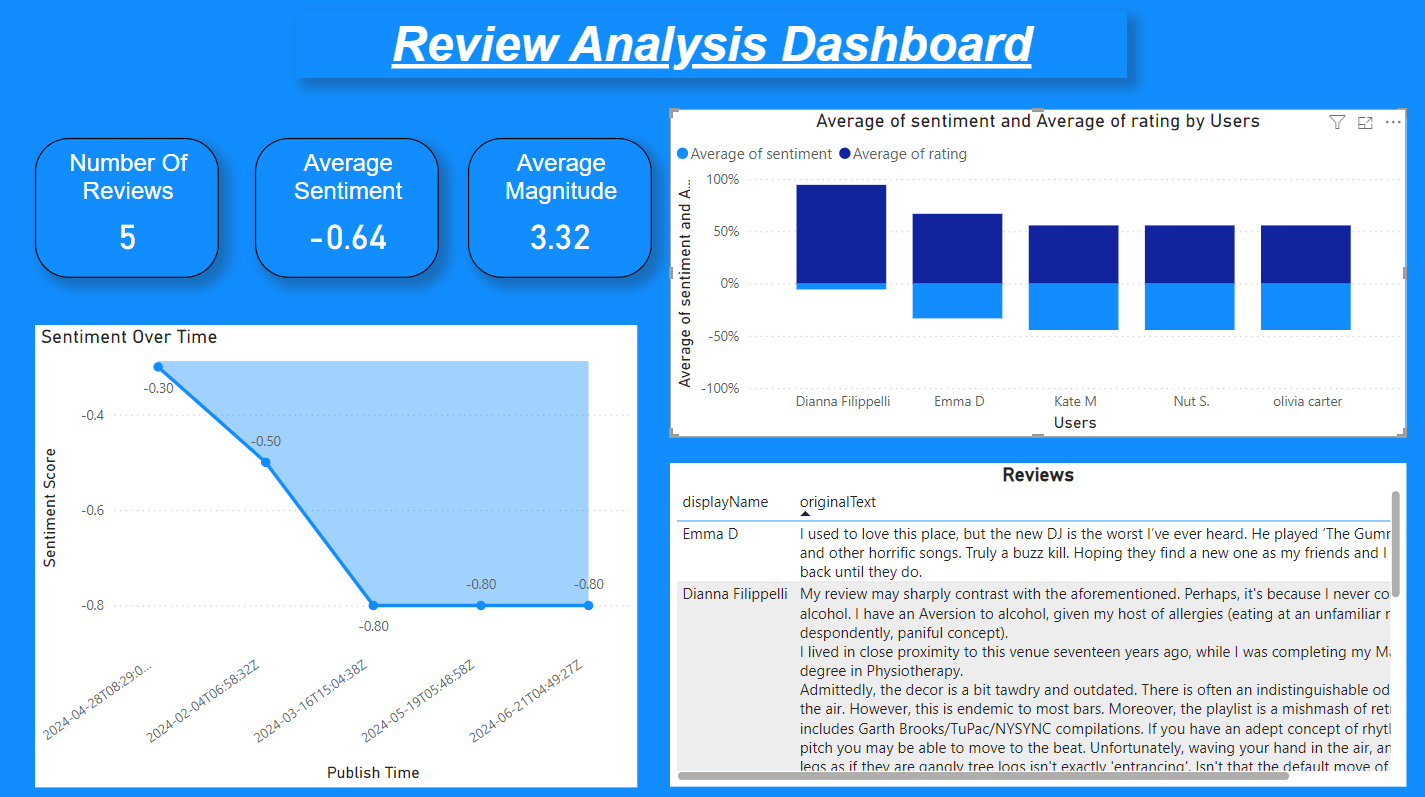

# **Consolidating Insights and Email Reporting**

In [56]:
# Send email report with review analysis
from datetime import  datetime
import smtplib
from email.mime.text import MIMEText
from email.mime.multipart import MIMEMultipart
import configparser
import pandas as pd

In [57]:
config = configparser.ConfigParser()
config.read('config.ini')

['config.ini']

In [58]:
# Send HTML Email Report
def send_html_email(subject,html_content, recipients, image_filename=None):

  # Create the email message
    msg = MIMEMultipart('mixed')
    msg['From'] = config['GMAIL']['sender']
    # Ensure recipients is a string, joining if it's a list
    msg['To'] = ", ".join(recipients) if isinstance(recipients, list) else recipients
    msg['Subject'] = subject

    # Attach HTML content to the email
    html_part = MIMEText(html_content, 'html')
    msg.attach(html_part)

    if image_filename:
        with open(image_filename, "rb") as f:
            attachment = MIMEBase("image", "png", f.read())
            attachment.set_header("Content-ID", f"<{image_filename}>")
            message.attach(attachment)

    # Connect to the SMTP server and send the email
    with smtplib.SMTP(config['GMAIL']['server'], config['GMAIL']['port']) as server:
        server.starttls()
        server.login(config['GMAIL']['sender'], config['GMAIL']['password'])
        server.send_message(msg)

    print("Email sent")

In [59]:
# Creating the Emal
subject = 'Review Analysis'

# Define the recipients of the email
recipients = ["sanilfernandes08@gmail.com"]  # Replace with actual email addresses

# Create HTML content with a link to the attached image
html_content = """
<!DOCTYPE HTML PUBLIC "-//W3C//DTD HTML 4.01 Transitional//EN" "http://www.w3.org/TR/html4/loose.dtd">
<html>
<head>
<meta http-equiv="content-type" content="text/html; charset=utf-8">
<title>REVIEW ANALYSIS</title>
</head>

<body style="background-color:#ffffff; color:#244b5a;">
    <center>
    <table cellpadding="0" border="0" cellspacing="0" style="width: 1300px; margin: 0 auto; color: #244b5a; background-color: #ffffff; border:1px solid #095795;">
        <!-- header image -->
        <tr>
            <td>
                <img alt="Review" src="https://snippdocs.blob.core.windows.net/docs/Sanil_Fernandes_Test%20/header.png" style="width:1300px; padding: 0; display: inline !important; vertical-align: bottom; border: 0; height: auto; outline: none; -ms-interpolation-mode: bicubic;" />
            </td>
        </tr>
        <!-- headline -->
        <tr>
            <td style="padding: 10px 30px 10px 30px;">
                <h1 style="font-size: 40px; font-family: Arial Black, sans-serif; color:#000000; text-transform: uppercase; font-weight: bold;">
                    REVIEW ANALYSIS
                </h1>
            </td>
        </tr>
        <!-- email body copy -->
        <tr align="center">
            <td align="center" style="padding: 5px 30px 30px 30px; width: 1300px;">
                <h1 style="font-size: 30px; font-family: Arial Black, sans-serif; color:#000000; text-transform: none; font-weight: bold;">
                    Your prefered Place - {place}
                </h1>
                <span style="margin:0px; mso-line-height-rule: exactly;-ms-text-size-adjust: 100%;-webkit-text-size-adjust: 100%; font-family: Arial, sans-serif; font-weight: bolder; font-size: 27px; text-align: left; line-height: 120%; color:#000000; text-transform: uppercase;">Your Word cloud</span>
                <br>
                <br>
                <img align="center" src="{url}" style="width:700px; padding: 0; display: inline !important; vertical-align: bottom; border: 0; height: auto; outline: none; -ms-interpolation-mode: bicubic;" />
            </td>
        </tr>
        <tr>
            <td style="padding: 5px 30px 30px 30px; width: 1300px;">
                <p style="margin:0px; mso-line-height-rule: exactly;-ms-text-size-adjust: 100%;-webkit-text-size-adjust: 100%; font-family: Arial, sans-serif; font-weight: regular; font-size: 20px; text-align: left; line-height: 120%; color:#000000;">
                    <span style="margin:0px; mso-line-height-rule: exactly;-ms-text-size-adjust: 100%;-webkit-text-size-adjust: 100%; font-family: Arial, sans-serif; font-weight: bolder; font-size: 27px; text-align: left; line-height: 120%; color:#000000; text-transform: uppercase;">Sentiment Summary</span>
                    <br>
                    <br>
                    <b>Average Sentiment:</b> {average_sentiment}
                    <br>
                    <br>
                    <b>Average Magnitude:</b> {average_magnitude}
                    <br>
                    <br>
                    <span style="margin:0px; mso-line-height-rule: exactly;-ms-text-size-adjust: 100%;-webkit-text-size-adjust: 100%; font-family: Arial, sans-serif; font-weight: bolder; font-size: 27px; text-align: left; line-height: 120%; color:#000000; text-transform: uppercase;">Customer Review Analysis Summary</span>
                    <br>
                    <br>
                    {html_table}
                    <br>
                    <br>
                    <span style="margin:0px; mso-line-height-rule: exactly;-ms-text-size-adjust: 100%;-webkit-text-size-adjust: 100%; font-family: Arial, sans-serif; font-weight: bolder; font-size: 27px; text-align: left; line-height: 120%; color:#000000; text-transform: uppercase;">Thankyou!</span>
                </p>
            </td>
        </tr>
        <!-- footer -->
        <tr>
            <td style="padding-top:10px; background-color:#000000;">
                <table cellpadding="0" border="0" cellspacing="0" style="width: 1300px; margin: 0 auto; color: #29acd8;">
                    <tr>
                        <td align="left" style="font-family: Arial, sans-serif;  font-size: 15px; padding-left:30px; line-height: 0%; width: 400px;">
                            <p style="color:#ffffff; margin-left: 0; padding-left: 0; font-size:18px; font-family: Arial, sans-serif;" >
                                <br>
                                © Copyright 2024. All rights reserved.
                            </p>
                        </td>
                    </tr>
                </table>
            </td>
        </tr>
    </table>
    </center>
</body>
</html>
"""

In [63]:
# Update the Placeholders in HTML table
updated_html_content = html_content.replace('{average_sentiment}', str(average_sentiment / 2.0)[:4])
updated_html_content = updated_html_content.replace('{average_magnitude}', str(average_magnitude / 2.0)[:4])
updated_html_content = updated_html_content.replace('{html_table}', str(html_table))
updated_html_content = updated_html_content.replace('{url}', get_signed_url("my_final_project", "images/wordcloud.png"))
updated_html_content = updated_html_content.replace('{place}', place)

In [61]:
send_html_email(subject, updated_html_content, recipients)

Email sent


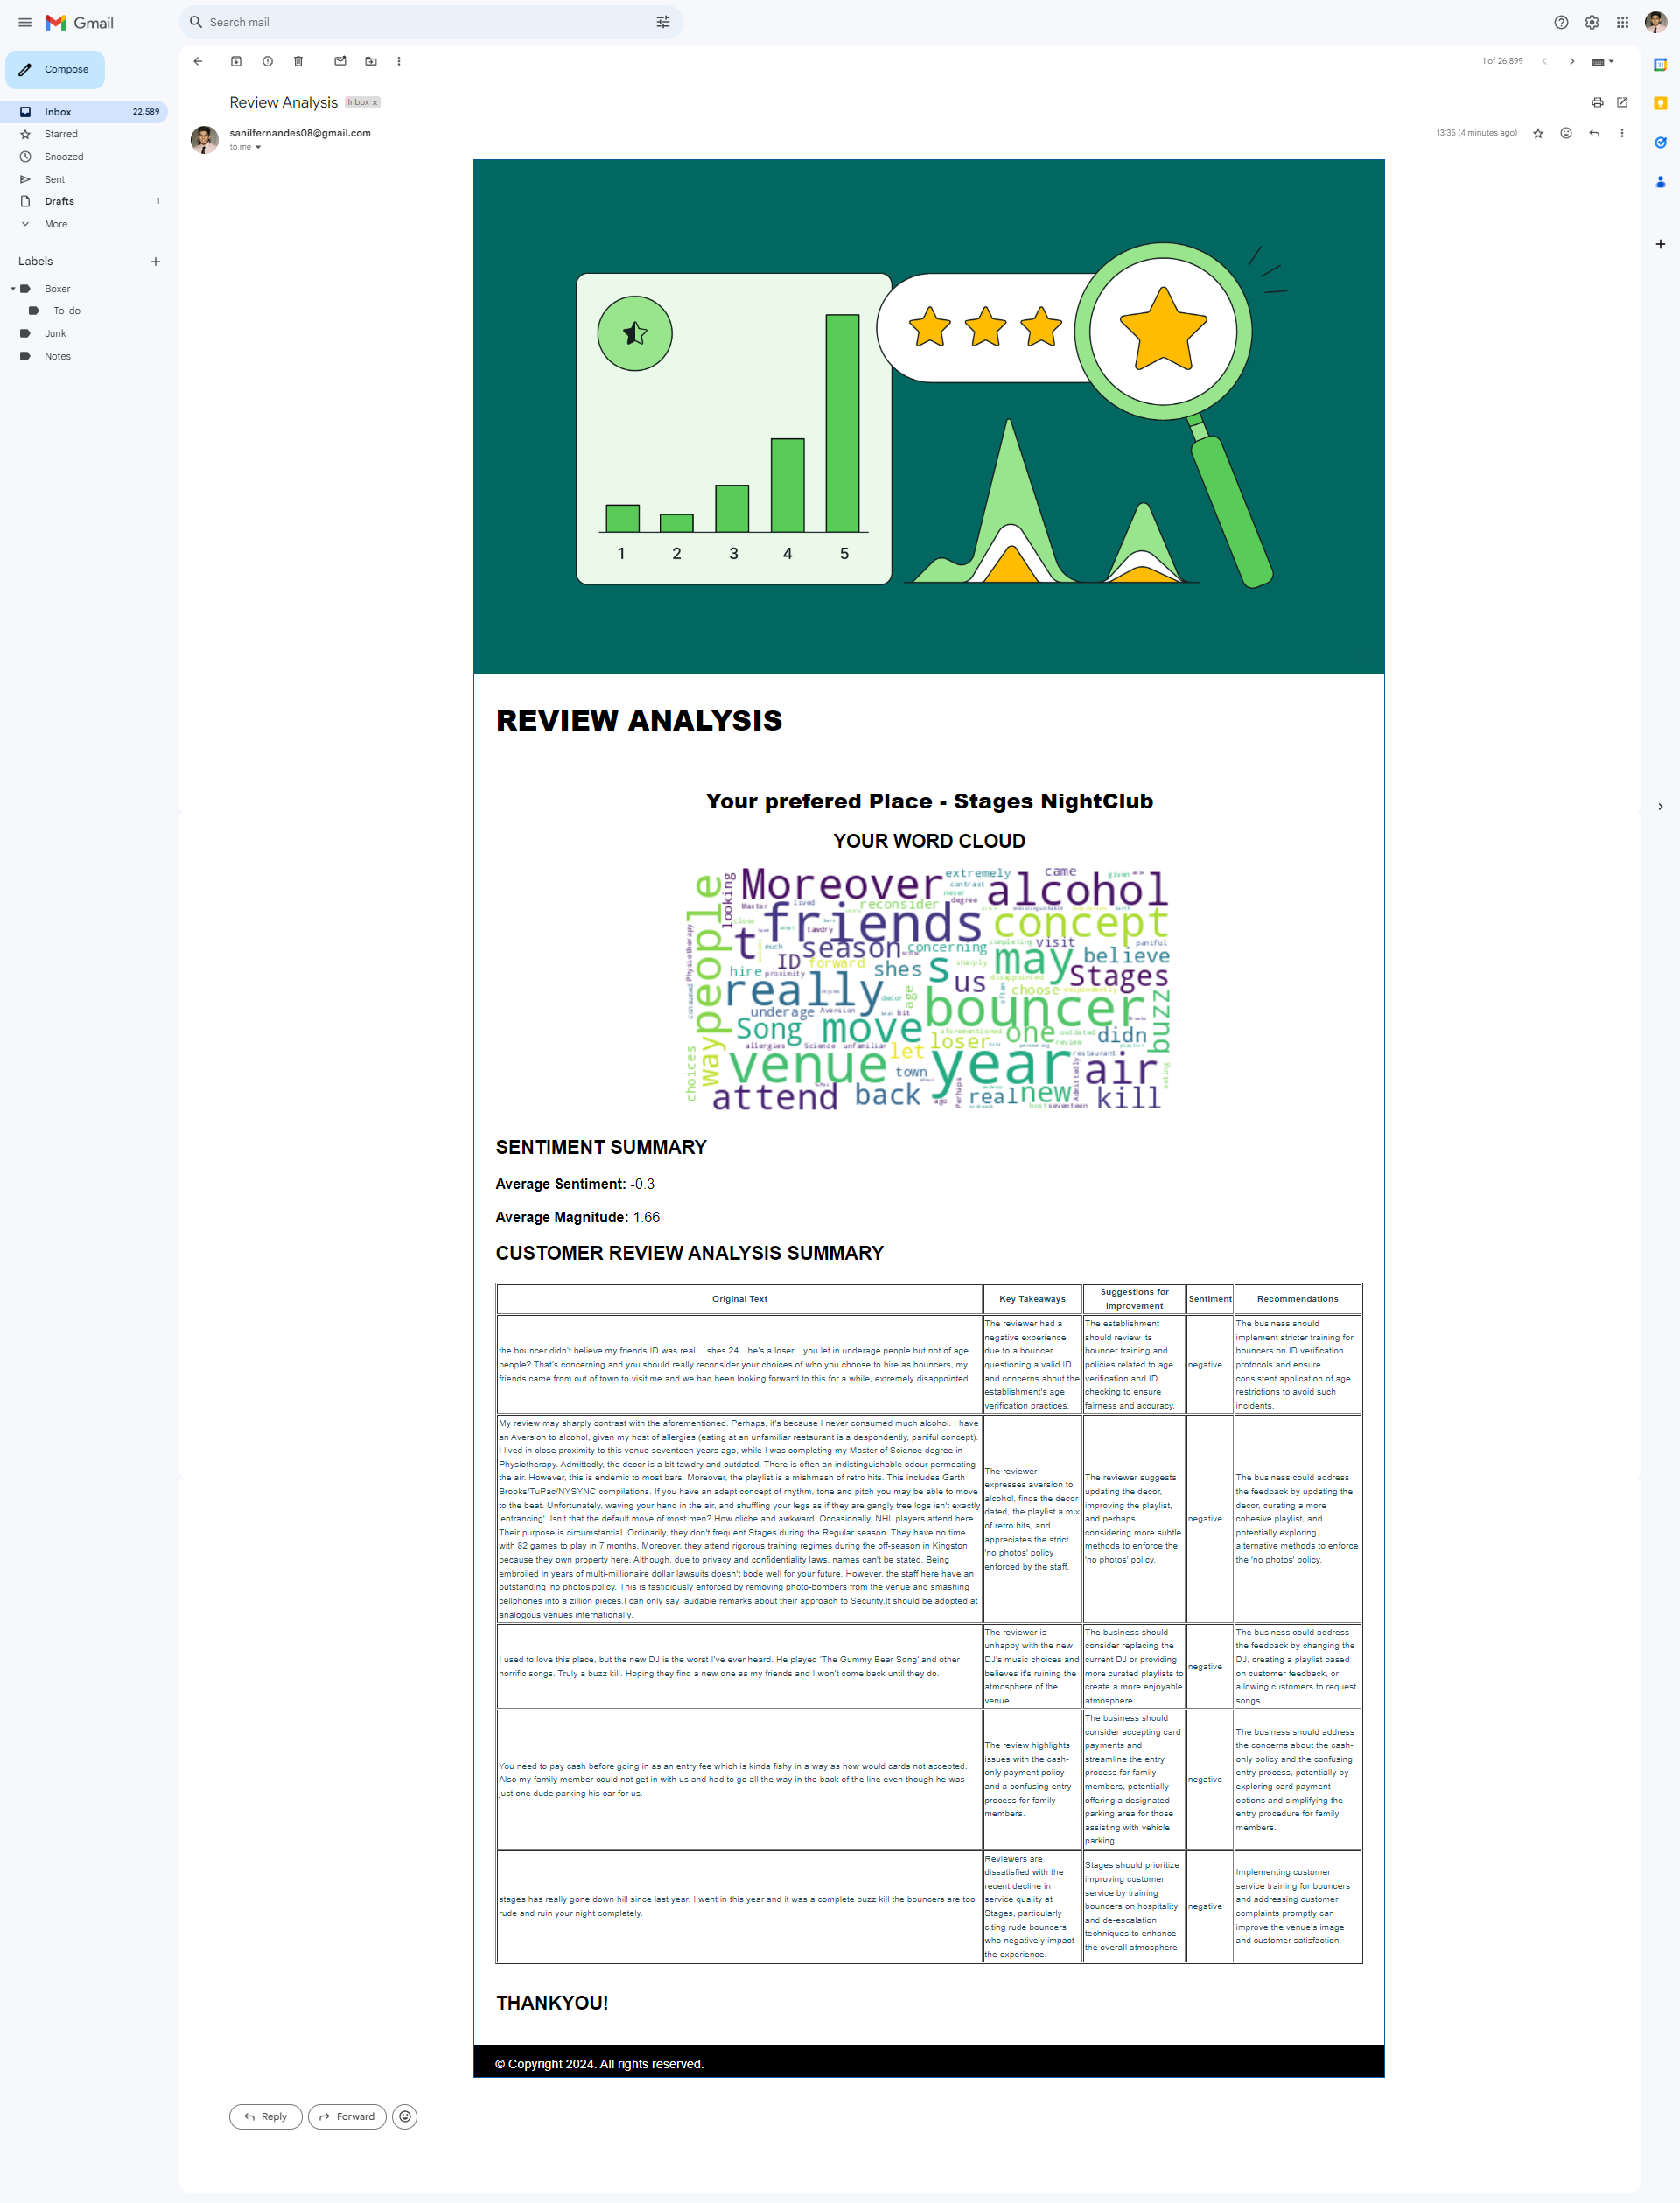

# **Conclusion**

This project successfully developed a system for analyzing customer sentiment from Google Maps reviews. By leveraging the Google Maps API, Gemini API, PowerBi BigQuery, and machine learning techniques, the project achieved the following:

* Data Acquisition: Retrieved relevant customer reviews for businesses from Google Maps.
* Data Cleaning and Preparation: Cleaned, transformed, and structured the data for effective sentiment analysis.
* Sentiment Analysis: Extracted sentiment scores from reviews, allowing businesses to understand customer satisfaction.
* Real-time Reviews Dashboard: Established a real-time dashboard in Power BI that visualizes key customer sentiment metrics. This allows businesses to monitor feedback and react promptly.
* Consolidated Insights and Reporting: Developed functionalities to send out email reports summarizing the analysis for businesses.

This system provides businesses with valuable insights into customer perception, enabling them to:

* Identify areas of improvement based on customer feedback.
* Respond to negative reviews and address customer concerns proactively.
* Track sentiment trends over time and measure the impact of business decisions.

Overall, this project demonstrates the effectiveness of utilizing machine learning and data visualization for analyzing customer sentiment from online reviews. The real-time nature of the system and the optional email reporting functionality further enhance its value for businesses seeking to stay informed about customer feedback.

**Future Work:**

* Explore the integration of additional data sources (e.g., social media reviews) for a more comprehensive understanding of customer sentiment.
* Implement more advanced sentiment analysis techniques to capture nuanced emotions within reviews.
* Develop features for sentiment analysis at the aspect level (identifying specific areas of the business that customers are commenting on).

This project lays a strong foundation for further development and exploration in the field of customer sentiment analysis using online reviews. By continuing to refine the system and explore additional functionalities, businesses can gain even deeper insights into customer feedback and make data-driven decisions to improve customer satisfaction.